In [1]:
import pandas as pd
import numpy as np
from random import sample
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import stochastic_gradient, SGDClassifier
from sklearn import neighbors
from sklearn import ensemble
from sklearn import neural_network

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
######### Data Preprocessing ##########
# Read train data
df_train = pd.read_json("train.json")
df_test = df_train.sample(frac=0.2)
df_train = pd.concat([df_train, df_test])
df_train.head()
df_train['ingredients'] = df_train['ingredients'].apply(','.join) # this converts ingredients columns into arrays
df_test['ingredients'] = df_test['ingredients'].apply(','.join)   # for test data, above one is for train data
X_train = df_train['ingredients']  # assigning a new variable for ingredients array(for train data)
X_test = df_test['ingredients']    # assigning a new variable for ingredients array(for test data)
Y_train = df_train['cuisine']
Y_test = df_test['cuisine']
encoder = preprocessing.LabelEncoder() #encoder for our y-values i.e cuisine
y_train_transformed = encoder.fit_transform(Y_train) 
y_test_transformed = encoder.fit_transform(Y_test) 
tf = TfidfVectorizer(binary = True) 
X_train_fitted = tf.fit(X_train.values)
X_test_fitted = tf.fit(X_test.values)
X_train_transformed = X_train_fitted.transform(X_train.values) #applying vectorizer for x-values of train set 
X_test_transformed = X_test_fitted.transform(X_test.values)   #applying vectorizer for x-values of test set

In [3]:
######### Data Preprocessing ##########

# Create cuisines and ingredients array
dictCuisineIngred = {}
cuisines = []
ingredients = []
with open('train.json') as data_file:    
    data = json.load(data_file)

for i in range(len(data)):

    cuisine = data[i]['cuisine']
    ingredientsPerCuisine = data[i]['ingredients']

    if cuisine not in dictCuisineIngred.keys():
        cuisines.append(cuisine)
        dictCuisineIngred[cuisine] = ingredientsPerCuisine

    else: 
        currentList = dictCuisineIngred[cuisine]
        currentList.extend(ingredientsPerCuisine)
        dictCuisineIngred[cuisine] = currentList

    ingredients.extend(ingredientsPerCuisine)

# unique list of ALL ingredients     
ingredients = list(set(ingredients)) 
numUniqueIngredients = len(ingredients)
numCuisines = len(cuisines)

   Training_Accuracy  Test_Accuracy  Train_Errors  Test_Errors  \
0           0.518798       0.536266      0.611274     0.648672   
1           0.557590       0.580138      0.622734     0.641866   
2           0.573973       0.604148      0.637380     0.638682   
3           0.578532       0.614456      0.636059     0.635030   
4           0.580557       0.626776      0.634470     0.638885   
5           0.589252       0.636329      0.636345     0.636968   
6           0.594874       0.647894      0.639300     0.637754   
7           0.600147       0.660717      0.643794     0.605070   
8           0.591452       0.669013      0.645428     0.591661   

   Training_Data_Size  Time_in_seconds_by_10  
0                10.0               0.026721  
1                20.0               0.054705  
2                30.0               0.094141  
3                40.0               0.139282  
4                50.0               0.193408  
5                60.0               0.242663  
6         

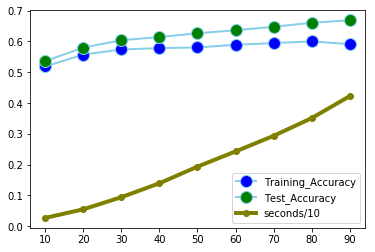

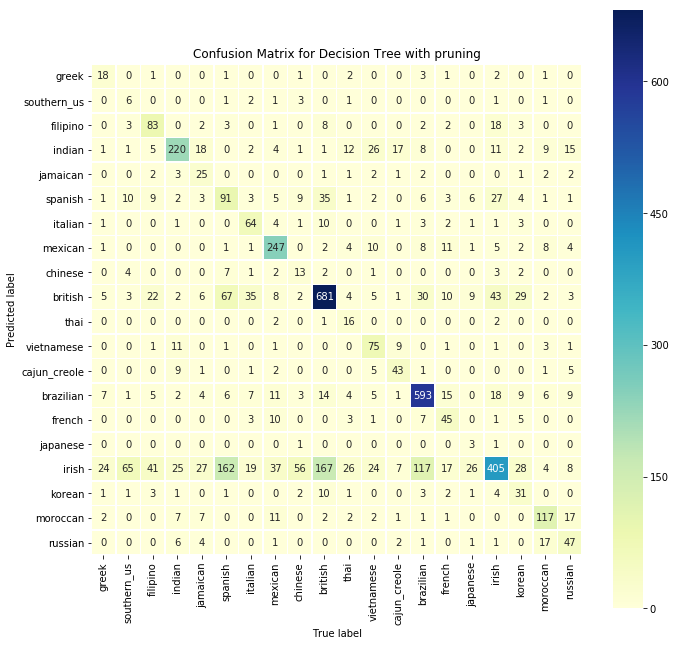

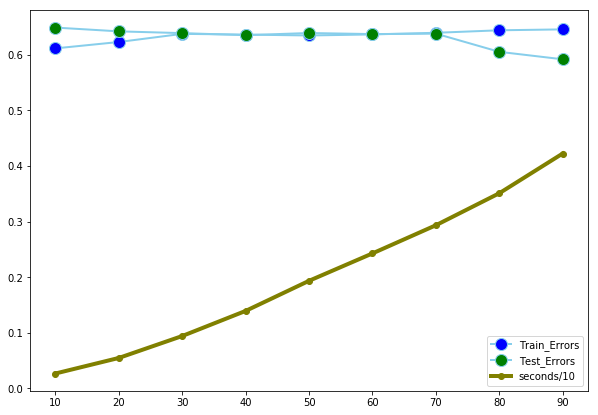

In [23]:
######### Decision Tree with Pruning ##########
index = 0
df_result = pd.DataFrame(columns=['Training_Accuracy','Test_Accuracy','Train_Errors','Test_Errors','Training_Data_Size', 'Time_in_seconds_by_10'])
# Cross validations on training set
for size in range (9,0,-1):
    t = datetime.now()
    test_size = size/10
    X_train_DT,X_test_DT,y_train_DT,y_test_DT = train_test_split(X_train_transformed, y_train_transformed ,test_size = test_size)
    tree = DecisionTreeClassifier(criterion="gini",
                 splitter="best",
                 max_depth=25,
                 min_samples_split=3,
                 min_samples_leaf=10,
                 min_weight_fraction_leaf=0.,
                 max_features=None,
                 random_state=15,
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 min_impurity_split=None,
                 class_weight=None,
                 presort=False)
    tree.fit(X_train_DT, y_train_DT)
    t_d = (datetime.now() - t).total_seconds() / 10
    y_test_pred_DT = tree.predict(X_test_DT)
    y_test_dataset_pred = tree.predict(X_test_transformed)

    train_accuracy = accuracy_score(y_test_DT, y_test_pred_DT)
    test_accuracy = accuracy_score(y_test_transformed, y_test_dataset_pred)
    train_errors = tree.fit(X_train_DT, y_train_DT).score(X_train_DT, y_train_DT)
    test_errors = tree.fit(X_test_DT, y_test_DT).score(X_test_DT, y_test_DT)
    
#     print('Train Accuracy = ', train_accuracy_DT, 'Test Accuracy = ', test_accuracy_DT, ' Train Size = ', 
#           100-(size * 10), 'Test Size = ', test_size * 100, 'Time required = ', t_d )
    df_result.loc[index] = [train_accuracy , test_accuracy, train_errors, test_errors,100-(size * 10),t_d]
    index = index + 1

print(df_result)
plt.plot( 'Training_Data_Size', 'Training_Accuracy', data=df_result, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Test_Accuracy', data=df_result, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

# Plot confusion matrix to understand prediction
mat_DT = confusion_matrix(y_test_DT, y_test_pred_DT)
fig, ax = plt.subplots(figsize=(11,11))  
ax.set_title("Confusion Matrix for Decision Tree with pruning")
sns.heatmap(mat_DT.T, square=True, annot=True, fmt='d', cbar=True,cmap="YlGnBu",
            xticklabels=cuisines,
            yticklabels=cuisines,linewidths=.5, ax=ax)
plt.xlabel('True label')
plt.ylabel('Predicted label');

# Classification Report
cls_report = classification_report(y_test_DT, y_test_pred_DT, target_names=cuisines)
print(cls_report)

plt.figure(figsize=(10,7))
plt.plot( 'Training_Data_Size', 'Train_Errors', data=df_result, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Test_Errors', data=df_result, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

Algorithm Implementation:
For decision tree learning algorithm, I pre processed the data using label encoder and TFIDF vectorizer. This processed data has been split into test and train dataset using `train_test_split` method of sklearn library. Decision tree learning classifier applied to 10% of training data and than used this classifier to classify 90% remaining data. I repeat this experiement for 20, 30,...,90% of training data. Implemented cross validation with range from 10 to 90% of data.

Analysis:
1) As I increased the size of training data, predictions were improving at the same time algorithm execution time were increasing.
2) Decision tree without pruning needed 1 second (for 10% training data) to 10 ( for 90% of training data ) seconds time to fit the data with test data accuracy ranges from 46% (for 10% training data) to 73% (for 90% training data). However while using pruning reduced the time significantly from 0.1 seconds to 5 seconds.
3) Pruning - To effectively prune the decision tree I used below parameters
    a) criterion - "gini". 
    b) splitter - "best". There are 2 possible value for splitter "best" and "random". However with random splitter I got incosistent accuarcy for same size of training set.
    c) max_depth - 25. It is quite visible that if you know 25 ingredients than you can easily identify the cuisine. Hence it's obvious to set the max_depth limit to 25. All trees deeper than 25 will be pruned.
    c) min_samples_split - 3. Looking at training set we can say that we need at least 3 number of ingredients to decide the cuisines hence we keep only those trees having at least 3 samples present. It has increased the accuracy by ~2%
    d) min_samples_leaf - 10. From multiple execution of algorithm, I concluded that best accuarcy and timings can be obtained when we prune trees having less than 10 leaf nodes. 
    e) random_state - 15. Used this parameter to seed the random number for DecisionTreeClassifier.
4) From the Confusion matrix created above, it's evident that DecisionTreeClassifier can classify British and Brazilian cuisines well while Irsish Spanish and Moroccan cuisines are failed to classify properly because they have many overlapping ingredients in other cuisines.
5) From Classification report we can clearly see that many cuisines are correctly classified more than 70% of time in reasonable amount of execution time.

NOTE: For this exercise, I used only pre-pruning technique for decision tree classifier 

   Training_Accuracy  Test_Accuracy  Train_Errors  Test_Errors  \
0           0.741230       0.770962      0.945725     0.857951   
1           0.765451       0.807291      0.912834     0.861041   
2           0.782317       0.831552      0.894469     0.865733   
3           0.788184       0.846889      0.881515     0.870382   
4           0.792709       0.856442      0.874581     0.872701   
5           0.798764       0.859962      0.867968     0.882307   
6           0.805294       0.871402      0.863514     0.892800   
7           0.810078       0.875801      0.860671     0.915986   
8           0.816468       0.878693      0.857086     0.950346   

   Training_Data_Size  Time_in_seconds_by_10  
0                10.0               0.011994  
1                20.0               0.017731  
2                30.0               0.027138  
3                40.0               0.040298  
4                50.0               0.055480  
5                60.0               0.083639  
6         

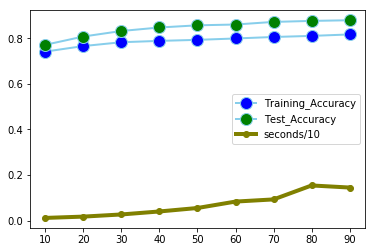

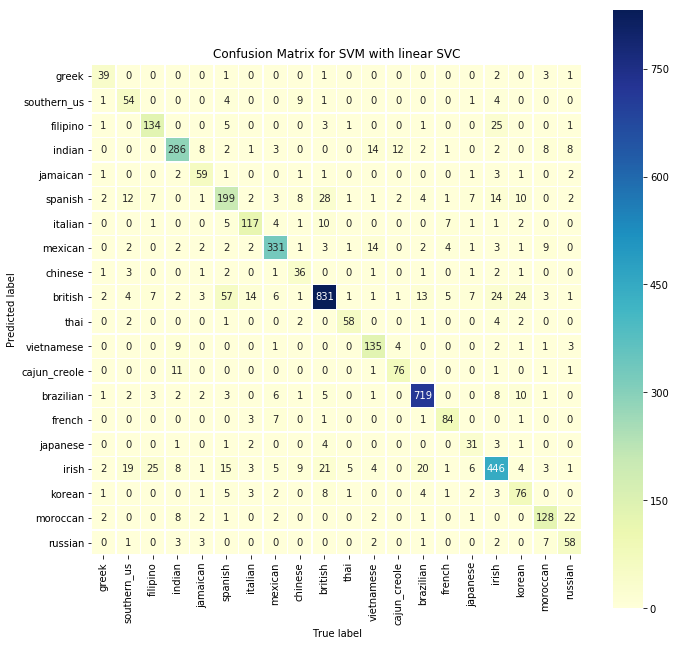

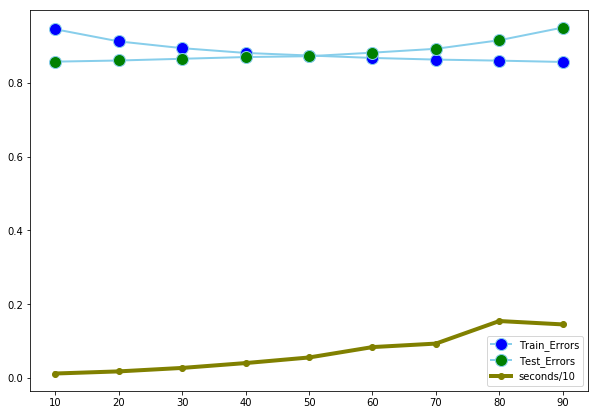

In [5]:
######### Support Vector Model Linear SVC##########

index = 0
df_result = pd.DataFrame(columns=['Training_Accuracy','Test_Accuracy', 'Train_Errors','Test_Errors','Training_Data_Size', 'Time_in_seconds_by_10'])
# Cross validations on training set
for size in range (9,0,-1):
    t = datetime.now()
    test_size = size/10

    # Processing SVM with linear SVC
    X_train_DT,X_test_DT,y_train_DT,y_test_DT = train_test_split(X_train_transformed, y_train_transformed ,test_size = test_size)
    linear_svc = svm.LinearSVC(random_state=42,C=1.0, class_weight=None, dual=True, fit_intercept=True,
         intercept_scaling=1, loss='squared_hinge', max_iter=1000,
         multi_class='ovr', penalty='l2', tol=0.01, verbose=0)
    
    linear_svc.fit(X_train_DT, y_train_DT)
    y_test_pred_DT = linear_svc.predict(X_test_DT)
    y_test_dataset_pred = linear_svc.predict(X_test_transformed)
    t_d = (datetime.now() - t).total_seconds() / 10
    training_accuracy = accuracy_score(y_test_DT, y_test_pred_DT)
    test_accuracy = accuracy_score(y_test_transformed, y_test_dataset_pred)
    train_errors = linear_svc.fit(X_train_DT, y_train_DT).score(X_train_DT, y_train_DT)
    test_errors = linear_svc.fit(X_test_DT, y_test_DT).score(X_test_DT, y_test_DT)
    df_result.loc[index] = [training_accuracy , test_accuracy, train_errors, test_errors,100-(size * 10),t_d]
    index = index + 1
    
print(df_result)
plt.plot( 'Training_Data_Size', 'Training_Accuracy', data=df_result, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Test_Accuracy', data=df_result, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

# Plot confusion matrix to understand prediction
mat_DT = confusion_matrix(y_test_DT, y_test_pred_DT)
fig, ax = plt.subplots(figsize=(11,11))  
ax.set_title("Confusion Matrix for SVM with linear SVC")
sns.heatmap(mat_DT.T, square=True, annot=True, fmt='d', cbar=True,cmap="YlGnBu",
            xticklabels=cuisines,
            yticklabels=cuisines,linewidths=.5, ax=ax)
plt.xlabel('True label')
plt.ylabel('Predicted label');

# Classification Report
cls_report = classification_report(y_test_DT, y_test_pred_DT, target_names=cuisines)
print(cls_report)

plt.figure(figsize=(10,7))
plt.plot( 'Training_Data_Size', 'Train_Errors', data=df_result, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Test_Errors', data=df_result, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

   Training_Accuracy  Test_Accuracy  Train_Errors  Test_Errors  \
0           0.681868       0.726336      0.961651     0.835603   
1           0.706133       0.772219      0.904138     0.840509   
2           0.723474       0.796480      0.871770     0.851127   
3           0.734968       0.815211      0.860405     0.857986   
4           0.747706       0.831050      0.843153     0.867169   
5           0.744081       0.835449      0.840800     0.880054   
6           0.747538       0.850534      0.838641     0.879391   
7           0.763880       0.861094      0.837755     0.919862   
8           0.770585       0.853426      0.834086     0.946365   

   Training_Data_Size  Time_in_seconds_by_10  
0                10.0               0.014933  
1                20.0               0.024290  
2                30.0               0.024421  
3                40.0               0.034041  
4                50.0               0.044611  
5                60.0               0.074784  
6         

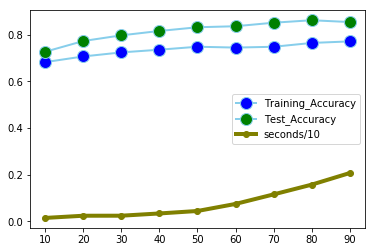

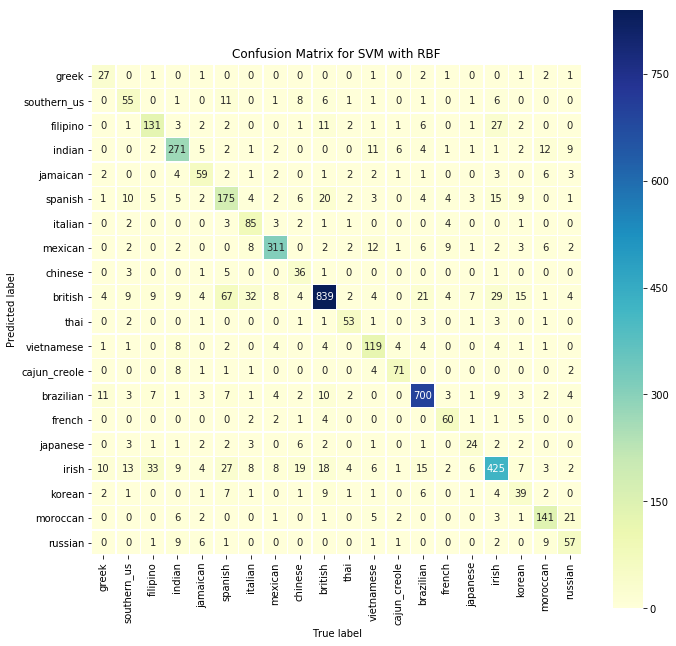

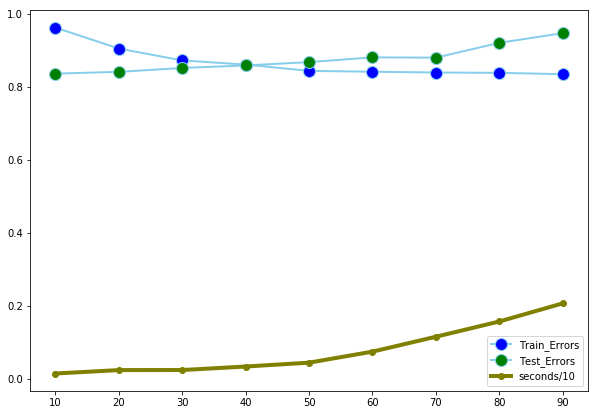

In [6]:
######### Support Vector Model with RBF ##########

# Cross validations on training set
index = 0
df_result = pd.DataFrame(columns=['Training_Accuracy','Test_Accuracy', 'Train_Errors','Test_Errors','Training_Data_Size', 'Time_in_seconds_by_10'])
for size in range (9,0,-1):
    t = datetime.now()
    test_size = size/10

    # Processing SVM with RBF kernel
    X_train_DT,X_test_DT,y_train_DT,y_test_DT = train_test_split(X_train_transformed, y_train_transformed ,test_size = test_size)
    rbf = SGDClassifier(loss="hinge", penalty='l1', alpha=0.00000003, l1_ratio=0, fit_intercept=True, max_iter=20000, tol=0.0001, shuffle=True,
                 verbose=False, epsilon=stochastic_gradient.DEFAULT_EPSILON, n_jobs=3, random_state=None, learning_rate="optimal", eta0=0.0, power_t=0.5,
                 class_weight=None, warm_start=True, average=False)
    
    rbf.fit(X_train_DT, y_train_DT)
    y_test_pred_DT = rbf.predict(X_test_DT)
    y_test_dataset_pred = rbf.predict(X_test_transformed)
    t_d = (datetime.now() - t).total_seconds() / 10
    training_accuracy = accuracy_score(y_test_DT, y_test_pred_DT)
    test_accuracy = accuracy_score(y_test_transformed, y_test_dataset_pred)    
    train_errors = rbf.fit(X_train_DT, y_train_DT).score(X_train_DT, y_train_DT)
    test_errors = rbf.fit(X_test_DT, y_test_DT).score(X_test_DT, y_test_DT)
    df_result.loc[index] = [training_accuracy , test_accuracy, train_errors, test_errors,100-(size * 10),t_d]
    index = index + 1

print(df_result)
# Prediction on Test data set
rbf.predict(X_test_transformed)
    
# print(df_result)
plt.plot( 'Training_Data_Size', 'Training_Accuracy', data=df_result, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Test_Accuracy', data=df_result, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

# Plot confusion matrix to understand prediction
mat_DT = confusion_matrix(y_test_DT, y_test_pred_DT)
fig, ax = plt.subplots(figsize=(11,11))  
ax.set_title("Confusion Matrix for SVM with RBF")
sns.heatmap(mat_DT.T, square=True, annot=True, fmt='d', cbar=True,cmap="YlGnBu",
            xticklabels=cuisines,
            yticklabels=cuisines,linewidths=.5, ax=ax)
plt.xlabel('True label')
plt.ylabel('Predicted label');

# Classification Report
cls_report = classification_report(y_test_DT, y_test_pred_DT, target_names=cuisines)
print(cls_report)

plt.figure(figsize=(10,7))
plt.plot( 'Training_Data_Size', 'Train_Errors', data=df_result, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Test_Errors', data=df_result, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

In [ ]:
######### KNN with N=3 and N=5 ##########

index=0
df_result = pd.DataFrame(columns=['K_Value','Training_Accuracy','Test_Accuracy','Train_Errors','Test_Errors','Training_Data_Size','Time_in_seconds_by_10'])
# Cross validations on training set
for size in range (9,6,-1):
    t = datetime.now()
    test_size = size/10

    # Processing KNN
    X_train_DT,X_test_DT,y_train_DT,y_test_DT = train_test_split(X_train_transformed, y_train_transformed ,test_size = test_size)
    for k in range (3,9,2):
        knn_clf = neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform', algorithm='auto', leaf_size=15, p=2,
                 metric='minkowski', metric_params=None, n_jobs=3)
        knn_clf.fit(X_train_DT, y_train_DT)
        y_test_pred_DT = knn_clf.predict(X_test_DT)
        y_test_dataset_pred = knn_clf.predict(X_test_transformed)
        t_d = (datetime.now() - t).total_seconds() / 10
        training_accuracy = accuracy_score(y_test_DT, y_test_pred_DT)
        test_accuracy = accuracy_score(y_test_transformed, y_test_dataset_pred)    
        train_errors = knn_clf.fit(X_train_DT, y_train_DT).score(X_train_DT, y_train_DT)
        test_errors = knn_clf.fit(X_test_DT, y_test_DT).score(X_test_DT, y_test_DT)
        df_result.loc[index] = [k, training_accuracy , test_accuracy, train_errors, test_errors,100-(size * 10),t_d]
        index = index + 1

df_result = df_result.sort_values(by=['K_Value'])
    
print(df_result)
plt.figure(figsize=(10,10))
plt.plot( 'Training_Data_Size', 'Training_Accuracy', data=df_result[df_result['K_Value']==3], marker='.', markerfacecolor='black', markersize=12, color='blue', linewidth=2, label="Train Accuracy : n=3")
plt.plot( 'Training_Data_Size', 'Training_Accuracy', data=df_result[df_result['K_Value']==5], marker='.', markerfacecolor='black', markersize=12, color='green', linewidth=2, label="Train Accuracy : n=5")
plt.plot( 'Training_Data_Size', 'Training_Accuracy', data=df_result[df_result['K_Value']==7], marker='.', markerfacecolor='black', markersize=12, color='red', linewidth=2, label="Train Accuracy : n=7")
plt.plot( 'Training_Data_Size', 'Training_Accuracy', data=df_result[df_result['K_Value']==9], marker='.', markerfacecolor='black', markersize=12, color='magenta', linewidth=2, label="Train Accuracy : n=9")
plt.plot( 'Training_Data_Size', 'Test_Accuracy', data=df_result[df_result['K_Value']==3], marker='.', markerfacecolor='black', markersize=12, color='blue', linestyle='dashed', linewidth=2, label="Test Accuracy : n=3")
plt.plot( 'Training_Data_Size', 'Test_Accuracy', data=df_result[df_result['K_Value']==5], marker='.', markerfacecolor='black', markersize=12, color='green', linestyle='dashed', linewidth=2, label="Test Accuracy : n=5")
plt.plot( 'Training_Data_Size', 'Test_Accuracy', data=df_result[df_result['K_Value']==7], marker='.', markerfacecolor='black', markersize=12, color='red', linestyle='dashed', linewidth=2, label="Test Accuracy : n=7")
plt.plot( 'Training_Data_Size', 'Test_Accuracy', data=df_result[df_result['K_Value']==9], marker='.', markerfacecolor='black', markersize=12, color='magenta', linestyle='dashed', linewidth=2, label="Test Accuracy : n=9")
#  plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

plt.figure(figsize=(10,10))
plt.plot( 'Training_Data_Size', 'Train_Errors', data=df_result[df_result['K_Value']==3], marker='.', markerfacecolor='black', markersize=12, color='blue', linewidth=2, label="Train Errors : n=3")
plt.plot( 'Training_Data_Size', 'Train_Errors', data=df_result[df_result['K_Value']==5], marker='.', markerfacecolor='black', markersize=12, color='green', linewidth=2, label="Train Errors : n=5")
plt.plot( 'Training_Data_Size', 'Train_Errors', data=df_result[df_result['K_Value']==7], marker='.', markerfacecolor='black', markersize=12, color='red', linewidth=2, label="Train Errors : n=7")
plt.plot( 'Training_Data_Size', 'Train_Errors', data=df_result[df_result['K_Value']==9], marker='.', markerfacecolor='black', markersize=12, color='magenta', linewidth=2, label="Train Errors : n=9")
plt.plot( 'Training_Data_Size', 'Test_Errors', data=df_result[df_result['K_Value']==3], marker='.', markerfacecolor='black', markersize=12, color='blue', linestyle='dashed', linewidth=2, label="Test Errors : n=3")
plt.plot( 'Training_Data_Size', 'Test_Errors', data=df_result[df_result['K_Value']==5], marker='.', markerfacecolor='black', markersize=12, color='green', linestyle='dashed', linewidth=2, label="Test Errors : n=5")
plt.plot( 'Training_Data_Size', 'Test_Errors', data=df_result[df_result['K_Value']==7], marker='.', markerfacecolor='black', markersize=12, color='red', linestyle='dashed', linewidth=2, label="Test Errors : n=7")
plt.plot( 'Training_Data_Size', 'Test_Errors', data=df_result[df_result['K_Value']==9], marker='.', markerfacecolor='black', markersize=12, color='magenta', linestyle='dashed', linewidth=2, label="Test Errors : n=9")
#  plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

1


   Training_Accuracy  Test_Accuracy  Train_Errors  Test_Errors  \
0           0.411388       0.411314      0.407795     0.545359   
1           0.459381       0.460465      0.463594     0.557301   
2           0.520517       0.518793      0.521442     0.554757   
3           0.523011       0.523947      0.527002     0.545289   
4           0.540499       0.537021      0.542114     0.542007   
5           0.534046       0.533124      0.533994     0.512361   
6           0.548502       0.549591      0.549686     0.469167   
7           0.558349       0.552357      0.551738     0.429604   
8           0.545569       0.545820      0.546047     0.365179   

   Training_Data_Size  Time_in_seconds_by_10  
0                10.0               0.172194  
1                20.0               0.236625  
2                30.0               0.286736  
3                40.0               0.359538  
4                50.0               0.404695  
5                60.0               0.463292  
6         

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


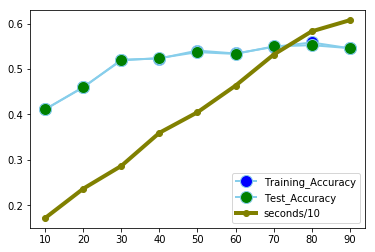

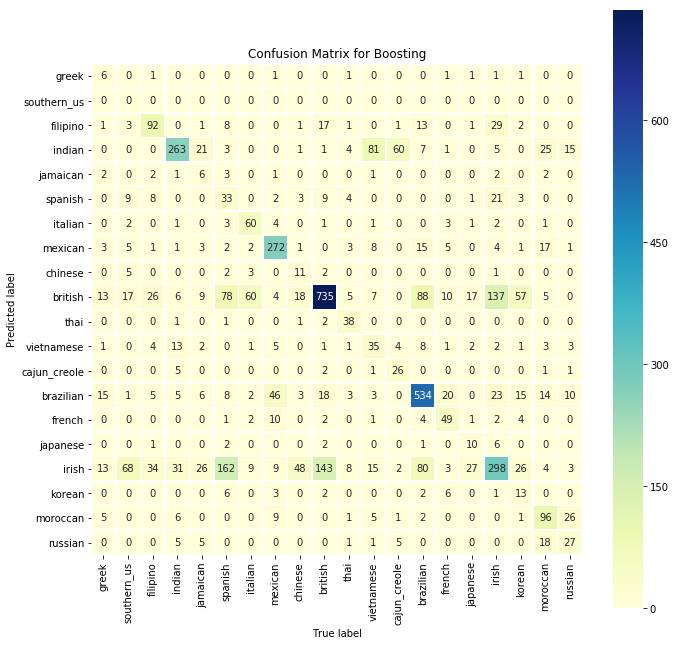

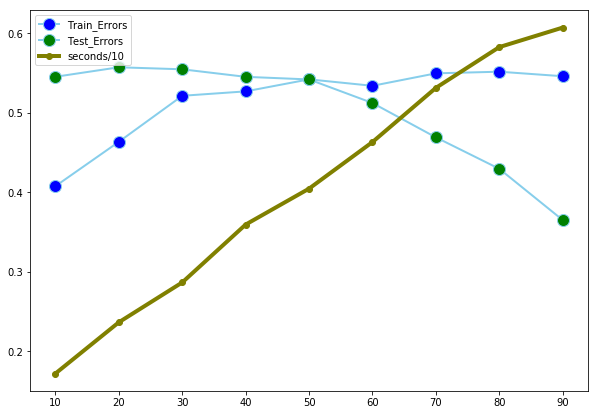

In [17]:
######### Boosting ##########

# Cross validations on training set
index = 0
df_result = pd.DataFrame(columns=['Training_Accuracy','Test_Accuracy', 'Train_Errors','Test_Errors','Training_Data_Size', 'Time_in_seconds_by_10'])
for size in range (9,0,-1):
    t = datetime.now()
    test_size = size/10

    # Processing Boosting
    X_train_DT,X_test_DT,y_train_DT,y_test_DT = train_test_split(X_train_transformed, y_train_transformed ,test_size = test_size)
    boosting = ensemble.AdaBoostClassifier( base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R',
                 random_state=42)
    
    boosting.fit(X_train_DT, y_train_DT)
    y_test_pred_DT = boosting.predict(X_test_DT)
    y_test_dataset_pred = boosting.predict(X_test_transformed)
    t_d = (datetime.now() - t).total_seconds() / 10
    training_accuracy = accuracy_score(y_test_DT, y_test_pred_DT)
    test_accuracy = accuracy_score(y_test_transformed, y_test_dataset_pred)    
    train_errors = boosting.fit(X_train_DT, y_train_DT).score(X_train_DT, y_train_DT)
    test_errors = boosting.fit(X_test_DT, y_test_DT).score(X_test_DT, y_test_DT)
    df_result.loc[index] = [training_accuracy , test_accuracy, train_errors, test_errors,100-(size * 10),t_d]
    index = index + 1

print(df_result)
    
# print(df_result)
plt.plot( 'Training_Data_Size', 'Training_Accuracy', data=df_result, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Test_Accuracy', data=df_result, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

# Plot confusion matrix to understand prediction
mat_DT = confusion_matrix(y_test_DT, y_test_pred_DT)
fig, ax = plt.subplots(figsize=(11,11))  
ax.set_title("Confusion Matrix for Boosting")
sns.heatmap(mat_DT.T, square=True, annot=True, fmt='d', cbar=True,cmap="YlGnBu",
            xticklabels=cuisines,
            yticklabels=cuisines,linewidths=.5, ax=ax)
plt.xlabel('True label')
plt.ylabel('Predicted label');

# Classification Report
cls_report = classification_report(y_test_DT, y_test_pred_DT, target_names=cuisines)
print(cls_report)

plt.figure(figsize=(10,7))
plt.plot( 'Training_Data_Size', 'Train_Errors', data=df_result, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Test_Errors', data=df_result, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

    Hidden_Layers  Training_Accuracy  Test_Accuracy  Train_Errors  \
0             3.0           0.195591       0.194343      0.196773   
4             3.0           0.196522       0.196103      0.198428   
8             3.0           0.214301       0.213576      0.214555   
12            3.0           0.332740       0.333375      0.337175   
16            3.0           0.343264       0.338529      0.335820   
20            3.0           0.339828       0.337146      0.337989   
24            3.0           0.341574       0.336644      0.335798   
28            3.0           0.339200       0.337901      0.338868   
32            3.0           0.331448       0.338026      0.340721   

    Test_Errors  Training_Data_Size  Time_in_seconds_by_10  
0      0.336848                10.0               0.040386  
4      0.337655                20.0               0.054293  
8      0.333273                30.0               0.084608  
12     0.338082                40.0               0.112703  
16  

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


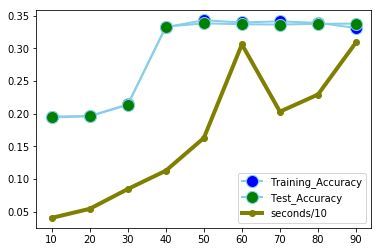

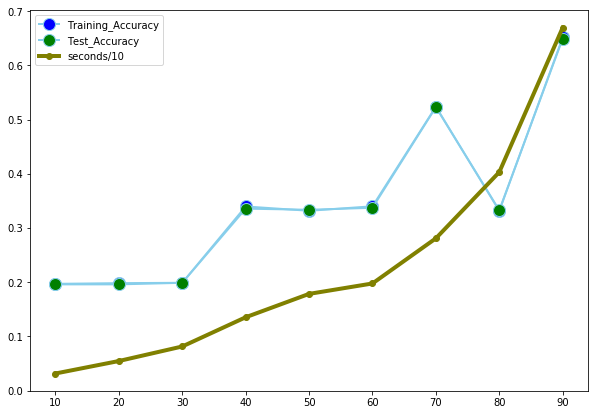

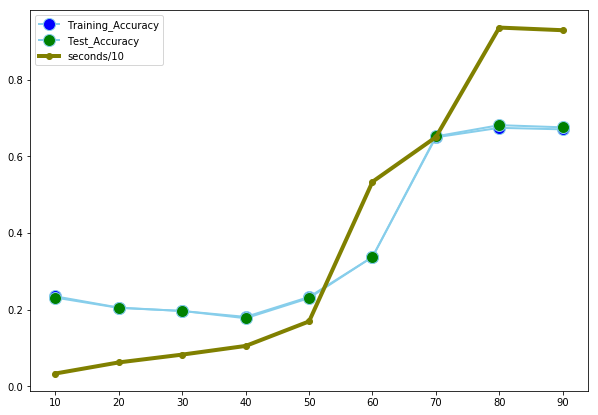

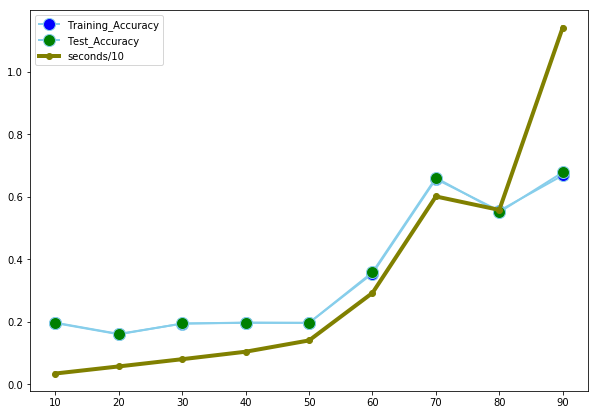

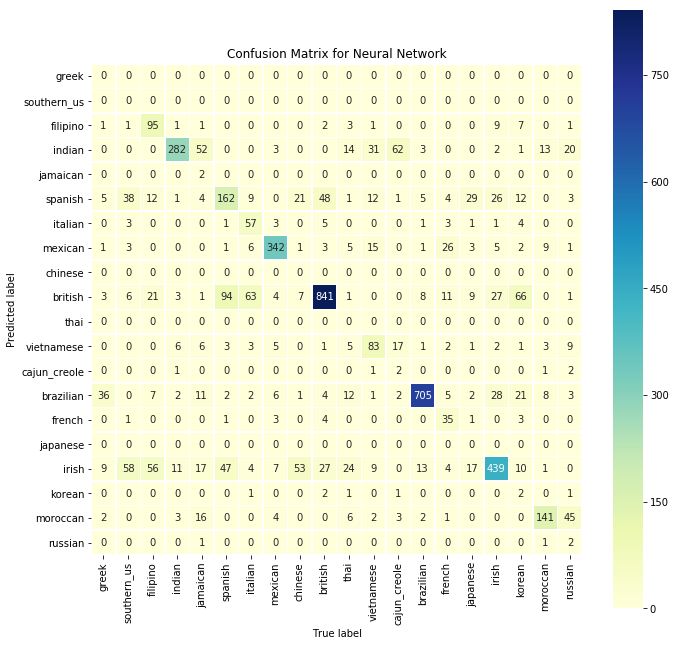

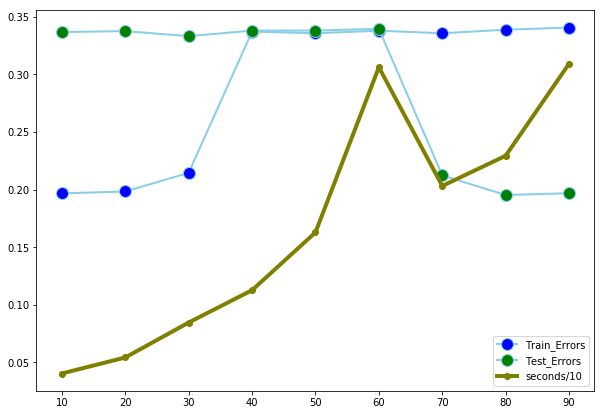

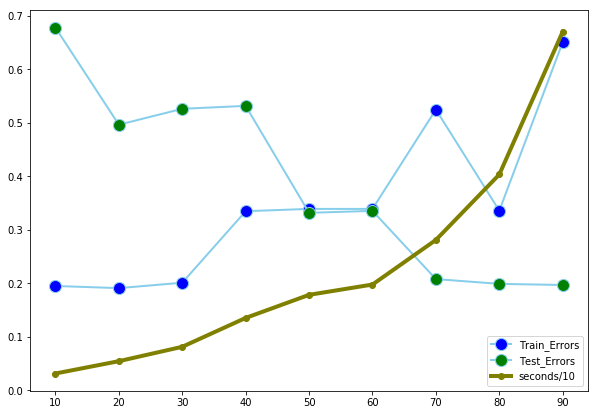

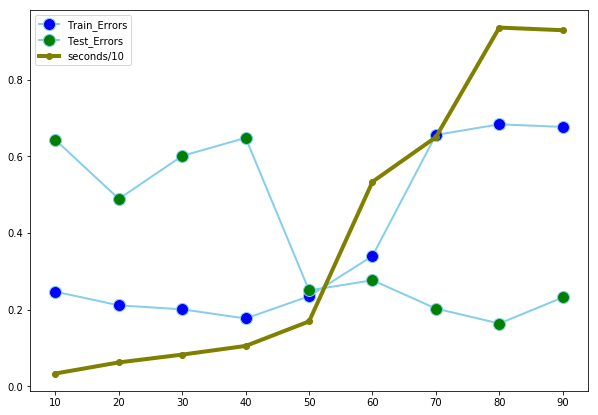

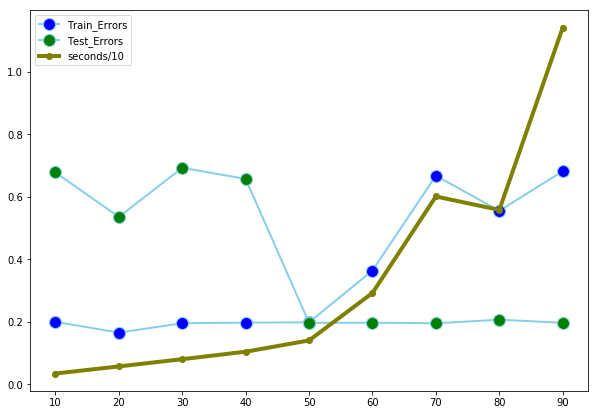

In [18]:
######### Neural Network ##########

# Cross validations on training set
index = 0
layer_size = 3
df_result = pd.DataFrame(columns=['Hidden_Layers','Training_Accuracy','Test_Accuracy', 'Train_Errors','Test_Errors','Training_Data_Size', 'Time_in_seconds_by_10'])
for size in range (9,0,-1):
    for layer_size in range (3,11,2):
        t = datetime.now()
        test_size = size/10

        # Processing Neural network
        X_train_DT,X_test_DT,y_train_DT,y_test_DT = train_test_split(X_train_transformed, y_train_transformed ,test_size = test_size)
        nn = neural_network.MLPClassifier( hidden_layer_sizes=layer_size, activation='identity', solver='sgd',alpha=0.1, batch_size=1000,
                learning_rate='adaptive',learning_rate_init=0.1,max_iter=10000,random_state=42, tol=0.001, momentum=0.5,early_stopping=True, 
                validation_fraction=0.01, beta_1=0.850, beta_2=0.2)

        nn.fit(X_train_DT, y_train_DT)
        y_test_pred_DT = nn.predict(X_test_DT)
        y_test_dataset_pred = nn.predict(X_test_transformed)
        t_d = (datetime.now() - t).total_seconds() / 10
        training_accuracy = accuracy_score(y_test_DT, y_test_pred_DT)
        test_accuracy = accuracy_score(y_test_transformed, y_test_dataset_pred)    
        train_errors = nn.fit(X_train_DT, y_train_DT).score(X_train_DT, y_train_DT)
        test_errors = nn.fit(X_test_DT, y_test_DT).score(X_test_DT, y_test_DT)
        df_result.loc[index] = [layer_size, training_accuracy , test_accuracy, train_errors, test_errors,100-(size * 10),t_d]
        index = index + 1

df_result = df_result.sort_values(by=['Hidden_Layers'])
df_result_3 = df_result[df_result['Hidden_Layers']==3].sort_values(by=['Training_Data_Size'])
print(df_result_3)
df_result_5 = df_result[df_result['Hidden_Layers']==5].sort_values(by=['Training_Data_Size'])
print(df_result_5)
df_result_7 = df_result[df_result['Hidden_Layers']==7].sort_values(by=['Training_Data_Size'])
print(df_result_7)
df_result_9 = df_result[df_result['Hidden_Layers']==9].sort_values(by=['Training_Data_Size'])
print(df_result_9)
     
plt.plot( 'Training_Data_Size', 'Training_Accuracy', data=df_result_3, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Test_Accuracy', data=df_result_3, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result_3, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

plt.figure(figsize=(10,7))
plt.plot( 'Training_Data_Size', 'Training_Accuracy', data=df_result_5, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Test_Accuracy', data=df_result_5, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result_5, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

plt.figure(figsize=(10,7))
plt.plot( 'Training_Data_Size', 'Training_Accuracy', data=df_result_7, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Test_Accuracy', data=df_result_7, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result_7, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

plt.figure(figsize=(10,7))
plt.plot( 'Training_Data_Size', 'Training_Accuracy', data=df_result_9, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Test_Accuracy', data=df_result_9, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result_9, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

# Plot confusion matrix to understand prediction
mat_DT = confusion_matrix(y_test_DT, y_test_pred_DT)
fig, ax = plt.subplots(figsize=(11,11))  
ax.set_title("Confusion Matrix for Neural Network")
sns.heatmap(mat_DT.T, square=True, annot=True, fmt='d', cbar=True,cmap="YlGnBu",
            xticklabels=cuisines,
            yticklabels=cuisines,linewidths=.5, ax=ax)
plt.xlabel('True label')
plt.ylabel('Predicted label');

# Classification Report
cls_report = classification_report(y_test_DT, y_test_pred_DT, target_names=cuisines)
print(cls_report)

plt.figure(figsize=(10,7))
plt.plot( 'Training_Data_Size', 'Train_Errors', data=df_result_3, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Test_Errors', data=df_result_3, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result_3, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

plt.figure(figsize=(10,7))
plt.plot( 'Training_Data_Size', 'Train_Errors', data=df_result_5, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Test_Errors', data=df_result_5, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result_5, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

plt.figure(figsize=(10,7))
plt.plot( 'Training_Data_Size', 'Train_Errors', data=df_result_7, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Test_Errors', data=df_result_7, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result_7, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()

plt.figure(figsize=(10,7))
plt.plot( 'Training_Data_Size', 'Train_Errors', data=df_result_9, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Test_Errors', data=df_result_9, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Training_Data_Size', 'Time_in_seconds_by_10', data=df_result_9, marker='o', color='olive', linewidth=4, label="seconds/10")
plt.legend()